#Install & Import Libraries


In [ ]:
!pip3 install pydub
!pip3 install xmltodict
!pip3 install resemblyzer
!pip3 install pyannote.core
!pip3 install noisereduce
!pip3 install pyannote.metrics
!pip3 install python_speech_features
!pip3 install spectralcluster
!pip3 install hdbscan
!pip3 install keras
!pip3 install tensorflow_addons

     |████████████████████████████████| 15.7MB 168kB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72322 sha256=59a89190a1ea3e3d29955acef6cbcaeca2bdfed2b4ddf96a59033bd8daef5770
  Stored in directory: /root/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
  Created wheel for typing: filename=typing-3.7.4.3-cp37-none-any.whl size=26308 sha256=6e2032f1e67090edcdd238e6f177b7c03b750f614889d632f975b1afbefdc961
  Stored in directory: /root/.cache/pip/wheels/2d/04/41/8e1836e79581989c22eebac3f4e70aaac9af07b0908da173be
Successfully built webrtcvad typing


     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 133kB 42.8MB/s 
  Created wheel for noisereduce: filename=noisereduce-1.1.0-cp37-none-any.whl size=7610 sha256=ba226480a367efff5a1f1506232eb0a1ac6fd89a480415f9bcdfe0fc6b89bd53
  Stored in directory: /root/.cache/pip/wheels/a6/2c/70/f9ccb41280dcfbe3eaeb7930f913dd85394617f3d3136f29cc
Successfully built noisereduce
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 92kB 11.4MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0
  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=caed89e4036b14732eed36bfd1468667d0079bf14a42863583136bf902426bd2
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# For importing code from drive
import sys
sys.path.append('/content/drive/MyDrive/ATML/code')

import VAD
from VAD import fxn, speech

# preprocess using mfcc
import preprocess
from preprocess import *

import model
from model import *

In [ ]:
from pydub import AudioSegment
import xmltodict
import os
os.path.join('a','b')

from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path
import numpy as np

from operator import itemgetter
from lxml import etree
import xml.etree.ElementTree as ET
import json

import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display
from math import ceil

from pyannote.core import Segment, Timeline, Annotation, notebook
import noisereduce as nr
from tqdm import tqdm

from python_speech_features import fbank
from random import choice

import numpy as np

#Data Preprocessing



In [ ]:
# Constants.

SAMPLE_RATE = 16000  # not higher than that otherwise we may have errors when computing the fbanks.

BATCH_SIZE = 32 * 3  # have to be a multiple of 3.

NUM_FRAMES = 44  
NUM_FBANKS = 20

In [ ]:
###################### PATH TO CORPUS & AUDIO FOLDER ######################
AMI_CORPUS_FOLDER = './drive/MyDrive/ATML/ami_public_manual_1.6.2/words'
AMI_CORPUS_FOLDER2 = './drive/MyDrive/amicorpusfinal/ami_public_manual_1.6.2/words'
AMI_AUDIO_FOLDER = './drive/MyDrive/ATML/amicorpus/'
AMI_AUDIO_FOLDER1 = './drive/MyDrive/amicorpus/'
AMI_AUDIO_FOLDER2 = './drive/MyDrive/amicorpusfinal/'
 
SPEAKERS = ['A', 'B', 'C', 'D']
X_FILENAME = 'X_withoutEmbedding_LSTM.txt'
Y_FILENAME = 'y_LSTM.txt'
TIME_FILENAME = 'startEndTime_LSTM.txt'

THRESHOLD_VAD = 0



In [ ]:
import pickle

def write(list1,filename):
  l = list1
  with open(filename, "wb") as fp:   #Pickling
    pickle.dump(l, fp)

def read(filename):
  with open(filename, "rb") as fp:   # Unpickling
    b = pickle.load(fp)
  return b


###Read Training Data


In [ ]:
# Code to read X_withoutEmbedding startEndTime y from txt file
# Put file names in WORKING_RECORDING_IDS list to get X_withoutEmbedding startEndTime y 

# WORKING_RECORDING_IDS = ['ES2002a','ES2004a','ES2005a','ES2006a','ES2007a','ES2009a','ES2010a','ES2011a','ES2012a','ES2006b','ES2007b','ES2009b','ES2010b','ES2011b','ES2012b']

TRAIN_WORKING_RECORDING_IDS = ['IS1000b', 'IS1001b', 'IS1002b', 'IS1003b', 'IS1004b', 'IS1005b', 'IS1006b', 
                               'TS3003b', 'TS3004b', 'TS3005b', 'TS3006b', 'TS3007b', 'TS3008b', 'TS3009b',
                               'ES2002a', 'ES2004a', 'ES2005a', 'ES2006a', 'ES2006b', 'ES2007a', 'ES2009a']


VAL_WORKING_RECORDING_IDS = ['IS1007b', 'IS1008b',
                             'TS3010b', 'TS3011b',
                             'ES2010a', 'ES2011a']

TEST_WORKING_RECORDING_IDS = [ 'IS1009b',
                              'TS3012b',
                              'ES2012a']

# For Reading stored Data
def read_all(RECORDING_ID,AMI_AUDIO_FOLDER):
  X_withoutEmbedding = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,X_FILENAME))
  y = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,Y_FILENAME))
  startEndTime = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,TIME_FILENAME))
  return X_withoutEmbedding, y, startEndTime

# For modifying time so that time will not overlap of different file 
def modifyTime(startEndTime):
  temp = [0]
  for i in range(1,len(startEndTime)):
    if(startEndTime[i][0]<startEndTime[i-1][0]):
      temp.append(temp[i-1]+startEndTime[i-1][1])
    else:
      temp.append(temp[i-1]) 
  for i in range(len(startEndTime)):
    startEndTime[i][0] = startEndTime[i][0] + temp[i] 
    startEndTime[i][1] = startEndTime[i][1] + temp[i]
  return temp

# Appending all the x,y vectors to create single x,y vector list
def createFinalList(WORKING_RECORDING_IDS,AMI_AUDIO_FOLDER):
  X_withoutEmbedding, y, startEndTime = read_all(WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER)
  for i in range(1,len(WORKING_RECORDING_IDS)):
    X_withoutEmbedding_temp, y_temp, startEndTime_temp = read_all(WORKING_RECORDING_IDS[i],AMI_AUDIO_FOLDER)
    ## modify y
    y_temp = [n + 4*i for n in y_temp]
    ## modify startEndTime
    startEndTime.extend(startEndTime_temp)
    modifyTime(startEndTime)
    X_withoutEmbedding.extend(X_withoutEmbedding_temp)
    y.extend(y_temp)
    
  return X_withoutEmbedding, y, startEndTime


## For DER Calculation
# X_withoutEmbedding, y, startEndTime = read_all(TRAIN_WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER2)
# X_withoutEmbedding_test, y_test, startEndTime_test = read_all(TEST_WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER2)

In [ ]:
## Read Dataset from Already Preprocessed Dataset

WORKING_RECORDING_IDS = ['IS1000b', 'IS1001b', 'IS1002b', 'IS1003b', 'IS1004b', 'IS1005b', 'IS1006b', 
                               'TS3003b', 'TS3004b', 'TS3005b', 'TS3006b', 'TS3007b', 'TS3008b', 'TS3009b',
                               'ES2002a', 'ES2004a', 'ES2005a', 'ES2006a', 'ES2006b', 'ES2007a', 'ES2009a',
                              'IS1007b', 'IS1008b',
                             'TS3010b', 'TS3011b',
                             'ES2010a', 'ES2011a']
X, y, _ = createFinalList(WORKING_RECORDING_IDS,AMI_AUDIO_FOLDER2)


### Create Tenserflow Dataset from Preprocessed Chunks + Labels



In [ ]:
from sklearn.model_selection import train_test_split

X_LSTM, X_LSTM_test, y_LSTM, y_LSTM_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [ ]:
X_LSTM = np.resize(X_LSTM, (len(X_LSTM), 74, 35))
X_LSTM_test = np.resize(X_LSTM_test, (len(X_LSTM_test), 74, 35))
print(X_LSTM.shape) 

(19776, 74, 35)


In [ ]:
print(len(y_LSTM))
print(np.unique(y_LSTM))

19776
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]


In [ ]:
print(len(y_LSTM_test))
print(np.unique(y_LSTM_test))

4945
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]


In [ ]:
# X_LSTM = np.array(X_LSTM)
# y_LSTM = np.array(y_LSTM)


# X_LSTM_test = np.array(X_LSTM_test)
# y_LSTM_test = np.array(y_LSTM_test)


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import keras.layers as layers


In [ ]:
# Modifing vector according to LSTM Model requirement

def map_data(data, label):
    return (data, label)

train_dataset = tf.data.Dataset.from_tensor_slices((X_LSTM, y_LSTM)) 
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.map(map_data)

## Uncomment this if using validation 

test_dataset = tf.data.Dataset.from_tensor_slices((X_LSTM_test, y_LSTM_test)) 
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(map_data)

In [ ]:
print(train_dataset)

<MapDataset shapes: ((None, 74, 35), (None,)), types: (tf.float32, tf.int32)>


# Create Embeddings using LSTM Model

###Define Hindi-English-BiLSTM Architecture and Triplet Net Model



In [ ]:
from keras.layers.core import Dense
from keras.layers import LSTM, Bidirectional, TimeDistributed, Dropout, Lambda
from keras.models import Model

model = keras.Sequential()

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(32)))
model.add(TimeDistributed(Dense(32)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

model.build(input_shape = (None, 74, 35)) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 74, 256)           167936    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 74, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 74, 32)            8224      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 74, 32)            1056      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 74, 1)             33        
Total params: 571,489
Trainable params: 571,489
Non-trainable params: 0
_________________________________________________________________



### Load Hindi-English-BiLSTM Model Weights


In [ ]:
h5_model_file = '/content/drive/My Drive/Hindi/model_hindi_2.h5'
model.load_weights(h5_model_file)

### Replace Dense Layers and Freeze BiLSTM layer weights




In [ ]:
# for layer in unfrozen_model.layers[:freeze_till_layer]:
#   layer.trainable =  False

model.layers[0].trainable = False
model.layers[1].trainable = False
# model2 = Model(model.input, model.layers[-4].output)
# model2.summary()

x = model.layers[-4].output 
x = LSTM(256)(x)
x = Dense(256, activation='tanh')(x)
x = Dropout(0.01)(x)
x = Dense(256, activation=None)(x)
x = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

model = Model(inputs = model.input, outputs =x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_input (InputLa [(None, 74, 35)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 74, 256)           167936    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 74, 256)           394240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792 

###Define Model Training Function

In [ ]:
from keras.callbacks import ModelCheckpoint
## Use CallBack to keep track of best performing model till yet and save its weights
best_model_file = "/content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss',
                             mode='min',
                             save_best_only=True,verbose=1)

In [ ]:
# Compiling Model
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.05), loss=tfa.losses.TripletHardLoss())

In [ ]:
'''
## fitting model
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[best_model])
'''

Epoch 1/50
618/618 [==============================] - 17s 19ms/step - loss: 0.5141 - val_loss: 0.4323

Epoch 00001: val_loss improved from inf to 0.43234, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 2/50
618/618 [==============================] - 10s 17ms/step - loss: 0.4381 - val_loss: 0.4173

Epoch 00002: val_loss improved from 0.43234 to 0.41727, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 3/50
618/618 [==============================] - 10s 17ms/step - loss: 0.4252 - val_loss: 0.4093

Epoch 00003: val_loss improved from 0.41727 to 0.40927, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 4/50
618/618 [==============================] - 10s 17ms/step - loss: 0.4166 - val_loss: 0.4038

Epoch 00004: val_loss improved from 0.40927 to 0.40382, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 5/50
618/618 [==============================] - 10s 16ms/step - loss: 0.4104 - val_loss: 0.3995

Epoch 00005: val_loss improved from 0.40382 to 0.39947, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 6/50
618/618 [==============================] - 10s 17ms/step - loss: 0.4057 - val_loss: 0.3962

Epoch 00006: val_loss improved from 0.39947 to 0.39618, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 7/50
618/618 [==============================] - 10s 16ms/step - loss: 0.4018 - val_loss: 0.3937

Epoch 00007: val_loss improved from 0.39618 to 0.39366, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 8/50
618/618 [==============================] - 10s 16ms/step - loss: 0.3983 - val_loss: 0.3915

Epoch 00008: val_loss improved from 0.39366 to 0.39148, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 9/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3953 - val_loss: 0.3897

Epoch 00009: val_loss improved from 0.39148 to 0.38973, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 10/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3929 - val_loss: 0.3881

Epoch 00010: val_loss improved from 0.38973 to 0.38812, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 11/50
618/618 [==============================] - 10s 16ms/step - loss: 0.3905 - val_loss: 0.3870

Epoch 00011: val_loss improved from 0.38812 to 0.38697, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 12/50
618/618 [==============================] - 10s 16ms/step - loss: 0.3885 - val_loss: 0.3859

Epoch 00012: val_loss improved from 0.38697 to 0.38593, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 13/50
618/618 [==============================] - 10s 16ms/step - loss: 0.3872 - val_loss: 0.3852

Epoch 00013: val_loss improved from 0.38593 to 0.38519, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 14/50
618/618 [==============================] - 10s 16ms/step - loss: 0.3856 - val_loss: 0.3844

Epoch 00014: val_loss improved from 0.38519 to 0.38441, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 15/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3840 - val_loss: 0.3835

Epoch 00015: val_loss improved from 0.38441 to 0.38352, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 16/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3825 - val_loss: 0.3831

Epoch 00016: val_loss improved from 0.38352 to 0.38311, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 17/50
618/618 [==============================] - 11s 18ms/step - loss: 0.3814 - val_loss: 0.3824

Epoch 00017: val_loss improved from 0.38311 to 0.38243, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 18/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3803 - val_loss: 0.3817

Epoch 00018: val_loss improved from 0.38243 to 0.38171, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 19/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3793 - val_loss: 0.3809

Epoch 00019: val_loss improved from 0.38171 to 0.38094, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 20/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3779 - val_loss: 0.3810

Epoch 00020: val_loss did not improve from 0.38094
Epoch 21/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3772 - val_loss: 0.3803

Epoch 00021: val_loss improved from 0.38094 to 0.38034, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 22/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3762 - val_loss: 0.3797

Epoch 00022: val_loss improved from 0.38034 to 0.37969, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 23/50
618/618 [==============================] - 11s 18ms/step - loss: 0.3754 - val_loss: 0.3796

Epoch 00023: val_loss improved from 0.37969 to 0.37964, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 24/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3747 - val_loss: 0.3793

Epoch 00024: val_loss improved from 0.37964 to 0.37928, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 25/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3738 - val_loss: 0.3789

Epoch 00025: val_loss improved from 0.37928 to 0.37888, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 26/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3728 - val_loss: 0.3788

Epoch 00026: val_loss improved from 0.37888 to 0.37881, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 27/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3728 - val_loss: 0.3787

Epoch 00027: val_loss improved from 0.37881 to 0.37868, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 28/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3717 - val_loss: 0.3786

Epoch 00028: val_loss improved from 0.37868 to 0.37856, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 29/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3707 - val_loss: 0.3779

Epoch 00029: val_loss improved from 0.37856 to 0.37787, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 30/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3700 - val_loss: 0.3777

Epoch 00030: val_loss improved from 0.37787 to 0.37767, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 31/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3691 - val_loss: 0.3777

Epoch 00031: val_loss improved from 0.37767 to 0.37766, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 32/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3693 - val_loss: 0.3779

Epoch 00032: val_loss did not improve from 0.37766
Epoch 33/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3690 - val_loss: 0.3777

Epoch 00033: val_loss improved from 0.37766 to 0.37765, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 34/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3676 - val_loss: 0.3771

Epoch 00034: val_loss improved from 0.37765 to 0.37709, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 35/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3675 - val_loss: 0.3767

Epoch 00035: val_loss improved from 0.37709 to 0.37669, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 36/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3668 - val_loss: 0.3768

Epoch 00036: val_loss did not improve from 0.37669
Epoch 37/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3659 - val_loss: 0.3766

Epoch 00037: val_loss improved from 0.37669 to 0.37658, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 38/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3660 - val_loss: 0.3762

Epoch 00038: val_loss improved from 0.37658 to 0.37621, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 39/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3657 - val_loss: 0.3766

Epoch 00039: val_loss did not improve from 0.37621
Epoch 40/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3649 - val_loss: 0.3766

Epoch 00040: val_loss did not improve from 0.37621
Epoch 41/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3652 - val_loss: 0.3760

Epoch 00041: val_loss improved from 0.37621 to 0.37596, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 42/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3645 - val_loss: 0.3762

Epoch 00042: val_loss did not improve from 0.37596
Epoch 43/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3636 - val_loss: 0.3757

Epoch 00043: val_loss improved from 0.37596 to 0.37575, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 44/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3633 - val_loss: 0.3758

Epoch 00044: val_loss did not improve from 0.37575
Epoch 45/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3630 - val_loss: 0.3760

Epoch 00045: val_loss did not improve from 0.37575
Epoch 46/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3628 - val_loss: 0.3753

Epoch 00046: val_loss improved from 0.37575 to 0.37535, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 47/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3620 - val_loss: 0.3761

Epoch 00047: val_loss did not improve from 0.37535
Epoch 48/50
618/618 [==============================] - 10s 17ms/step - loss: 0.3620 - val_loss: 0.3759

Epoch 00048: val_loss did not improve from 0.37535
Epoch 49/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3616 - val_loss: 0.3753

Epoch 00049: val_loss improved from 0.37535 to 0.37534, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD.hs/assets


Epoch 50/50
618/618 [==============================] - 11s 17ms/step - loss: 0.3614 - val_loss: 0.3756

Epoch 00050: val_loss did not improve from 0.37534


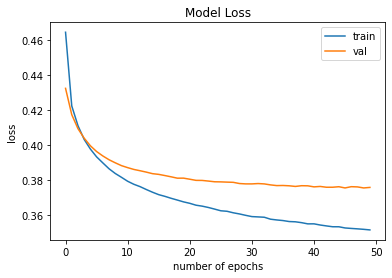

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('number of epochs')
plt.legend((['train', 'val']), loc='upper right')
plt.show()

In [ ]:
'''
## Uncomment this code to save the model history obtained at the end of training
with open('/content/drive/MyDrive/LSTM_keras_50epochs_completedata_history_SGD_003_005', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
'''

In [ ]:
'''
## Uncomment this code to save the model weights obtained at training for all the epochs
model.save('/content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD_50epochs.h5')
'''

In [ ]:
#  with open('/content/drive/MyDrive/LSTM_keras_100epochs_completedata_history', 'wb') as file_pi:
#         pickle.dump(history.history, file_pi)

In [ ]:
model.load_weights('/content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_LSTM_Freeze_Best_SGD_50epochs.h5')

In [ ]:
# model.evaluate(X_LSTM, y_LSTM)
# model.evaluate(X_LSTM_test, y_LSTM_test)

In [ ]:
## Creating X, y, start end time vector on train and test data for DER calculation

## Training data
X_withoutEmbedding, y, startEndTime = read_all(TRAIN_WORKING_RECORDING_IDS[19],AMI_AUDIO_FOLDER2)

## Unknown test data
X_withoutEmbedding_test, y_test, startEndTime_test = read_all(TEST_WORKING_RECORDING_IDS[2],AMI_AUDIO_FOLDER2)

X_withoutEmbedding = np.resize(X_withoutEmbedding, (len(X_withoutEmbedding), 74, 35))

X_withoutEmbedding_test = np.resize(X_withoutEmbedding_test, (len(X_withoutEmbedding_test), 74, 35))



In [ ]:
## Modifing train data according to LSTM Model requirement
train_dataset_embedding = tf.data.Dataset.from_tensor_slices((X_withoutEmbedding, y)) 
train_dataset_embedding = train_dataset_embedding.batch(32)
train_dataset_embedding = train_dataset_embedding.map(map_data)

## Modifing test data according to LSTM Model requirement
test_dataset_embedding = tf.data.Dataset.from_tensor_slices((X_withoutEmbedding_test, y_test)) 
test_dataset_embedding = test_dataset_embedding.batch(32)
test_dataset_embedding = test_dataset_embedding.map(map_data)

In [ ]:
# Creating embedding from trained LSTM Model on train and test data

train_embeddings_tl, train_labels_tl = model.predict(train_dataset_embedding), y
test_embeddings_tl, test_labels_tl = model.predict(test_dataset_embedding), y_test


In [ ]:
print(test_embeddings_tl)

[[ 0.06046629 -0.00845939 -0.02389606 ... -0.01882804 -0.02421719
  -0.02389446]
 [ 0.02567459  0.01962965 -0.05021861 ... -0.07881721 -0.07611573
   0.12595895]
 [-0.04899456  0.01723723  0.10839094 ... -0.05940299  0.01433154
  -0.05288463]
 ...
 [ 0.00276963 -0.0977071  -0.05259717 ... -0.06551478 -0.14237915
   0.08318961]
 [ 0.06441254 -0.06073616 -0.01853612 ... -0.05156058 -0.16533421
   0.03462043]
 [ 0.00820329  0.01473704 -0.13842471 ...  0.05184991 -0.02075749
   0.10314642]]


In [ ]:
## Extract Embeddings
X, y = np.array(train_embeddings_tl), np.array([int(i) for i in train_labels_tl])

In [ ]:
X_test, y_test =  np.array(test_embeddings_tl), np.array([int(i) for i in test_labels_tl])

# Cluster Plot of Embeddings

####PCA for Dataset Emebeddings (with True Labels)


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA

def preprocessingX(X):
  # Preprocessing the data to make it visualizable 
  raw_df = pd.DataFrame(X)  

  # Scaling the Data 
  scaler = StandardScaler() 
  X_scaled = scaler.fit_transform(raw_df) 

  # Normalizing the Data 
  X_normalized = preprocessing.normalize(X_scaled) 

  # Converting the numpy array into a pandas DataFrame 
  X_normalized = pd.DataFrame(X_normalized) 

  # Reducing the dimensions of the data 
  pca = PCA(n_components = 2) 
  X_principal = pca.fit_transform(X_normalized) 
  X_principal = pd.DataFrame(X_principal) 
  X_principal.columns = ['P1', 'P2'] 
  return X_principal

X_principal = preprocessingX(X)
X_principal_test = preprocessingX(X_test)

X_principal.head(2) 

,P1,P2
0,-0.314240,0.034599
1,-0.154483,0.096268


###Plot of Spectral Clustering When exact number of speakers known

####Using Radial Basis Function 


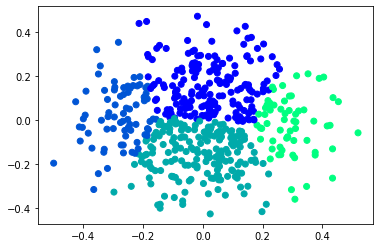

In [ ]:
from sklearn.cluster import SpectralClustering

# Building the clustering model 
spectral_model_rbf = SpectralClustering(n_clusters = 4, affinity ='rbf') 

# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(X_principal)

# Visualizing the clustering
plt.scatter(X_principal['P1'], X_principal['P2'],
           c = SpectralClustering(n_clusters = 4, affinity ='rbf') .fit_predict(X_principal), cmap =plt.cm.winter) 
plt.show() 

####Using Nearest Neighbours function

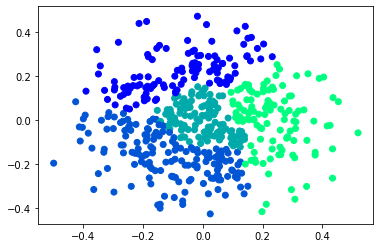

In [ ]:
# Building the clustering model 
spectral_model_nn = SpectralClustering(n_clusters = 4, affinity ='nearest_neighbors') 
  
# Training the model and Storing the predicted cluster labels 
labels_nn = spectral_model_nn.fit_predict(X_principal)

# Visualizing the clustering 
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = SpectralClustering(n_clusters = 4, affinity ='nearest_neighbors') .fit_predict(X_principal), cmap =plt.cm.winter) 
plt.show() 

###Plot of Spectral Clustering When number of speaker not known beforehand


### Scatter Plot with True Labels as color vector (4 clusters -> 4 speakers)

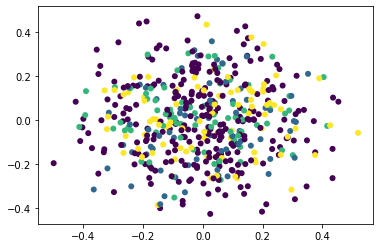

In [ ]:
c = np.random.choice(range(4), 100)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_principal['P1'], X_principal['P2'], c=y, lw=0)

#### Using Spectral Clustering Algorithm

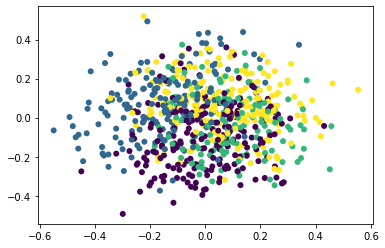

In [ ]:
from spectralcluster import SpectralClusterer

clusterer1 = SpectralClusterer(
    min_clusters=4,
    max_clusters=100,
    p_percentile=0.95,
    gaussian_blur_sigma=0.25)

labels1 = clusterer1.predict(X)
labels_test1 = clusterer1.predict(X_test)

c = np.random.choice(range(4), 100)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_principal_test['P1'], X_principal_test['P2'], c=labels_test1, lw=0)


#### Using Agglomerative Heirarchical Clustering Function

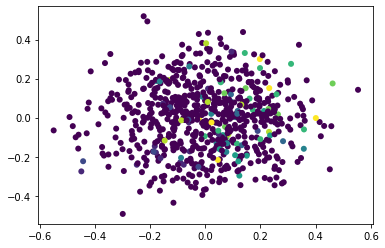

In [ ]:
import hdbscan

clusterer2 = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=4, min_samples=None, p=None)

clusterer2.fit(X)
labels2 = clusterer2.labels_

clusterer2.fit(X_test)
labels_test2 = clusterer2.labels_

c = np.random.choice(range(4), 100)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_principal_test['P1'], X_principal_test['P2'], c=labels_test2, lw=0)

# Make Predictions Using Embeddings


### Calculate DER values

In [ ]:
## Create Helper Fucntions to Compute DER
from pyannote.metrics.diarization import DiarizationErrorRate, GreedyDiarizationErrorRate, JaccardErrorRate

## Compute Speeker Segments from Model output
def get_hypothesis(speaker_segments):
    hypothesis = Annotation()
    for t in speaker_segments:
        try:
            hypothesis[Segment(t['start'], t['end'])] = f"{t['speaker_id']}_hyp"
        except:
            pass
        
    return hypothesis

## Compute Speeker Segments from Ground Truth
def get_ref(speaker_segments):
    reference = Annotation()
    for t in speaker_segments:
        try:
            reference[Segment(t['start'], t['end'])] = f"{t['speaker_id']}_ref"
        except:
            pass
        
    return reference

der = DiarizationErrorRate()
gder = GreedyDiarizationErrorRate()
jer = JaccardErrorRate()

## Compute DER
def measure_metrics(reference, hypothesis):
    der_value = der(reference, hypothesis)
    print('DER:', der_value)

    
    return der_value

In [ ]:
## Compute Speaker Start End Time Segments
def ref_hypo(startEndTime,startEndTime_ref,labels,y):
  speaker_segments = []
  for i in range(len(startEndTime)):
    speaker_segments.append({
                        'start': startEndTime[i][0],
                        'end': startEndTime[i][1],
                        'speaker_id': labels[i]
                    })
  speaker_segments_ref = []
  for i in range(len(startEndTime_ref)):
    speaker_segments_ref.append({
                        'start': startEndTime_ref[i][0],
                        'end': startEndTime_ref[i][1],
                        'speaker_id': y[i]
                    })
  return speaker_segments,speaker_segments_ref

# labels = labels1
labels = labels2

# labels_test = labels_test1
labels_test = labels_test2

speaker_segments,speaker_segments_ref = ref_hypo(startEndTime,startEndTime,labels,y)
speaker_segments_test,speaker_segments_ref_test = ref_hypo(startEndTime_test,startEndTime_test,labels_test,y_test)



In [ ]:
# DER for Training data
hypothesis = get_hypothesis(speaker_segments)
reference = get_ref(speaker_segments_ref)
der_value = measure_metrics(reference, hypothesis)

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


DER: 0.518664047151277


In [ ]:
## Der for test data
hypothesis_test = get_hypothesis(speaker_segments_test)
reference_test = get_ref(speaker_segments_ref_test)
der_value = measure_metrics(reference_test, hypothesis_test)

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


DER: 0.3911806543385491


### Visualise Overall Diarization Outcome 

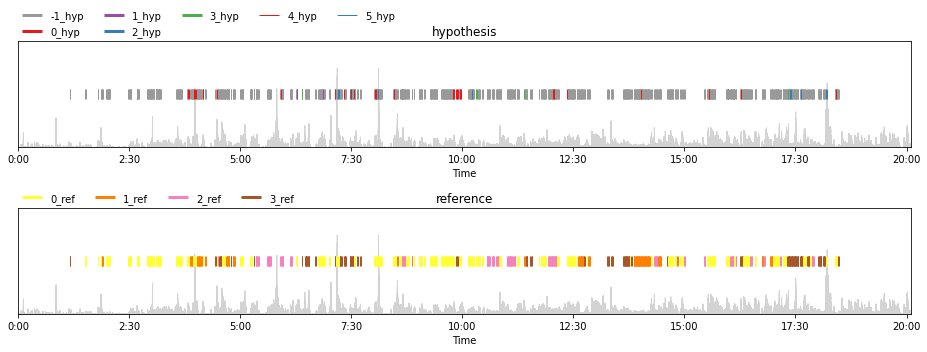

In [ ]:
import matplotlib
from matplotlib import style
import datetime
import librosa
import librosa.display

## Visualise Model Outputs as compared against the Ground Truth

def timeTicks(x, pos):
    d = datetime.timedelta(seconds=x)
    return str(d)[-5:] if x < 3600 else str(d)
formatter = matplotlib.ticker.FuncFormatter(timeTicks)

SR = 32000

def plot_der(FILEPATH,reference,hypothesis):
    fig = plt.figure(figsize=(13, 5))

    # plot hypothesis
    ax = plt.subplot(211)
    plt.title('hypothesis')
    ax.xaxis.set_major_formatter(formatter)
    wav, source_sr = librosa.load(FILEPATH, sr=SR)
    ticks_freq = ceil(len(wav) * .1 / source_sr)

    notebook.plot_annotation(hypothesis, legend=True, time=True)
    librosa.display.waveplot(wav, sr=source_sr, color='lightgray')

    # plot reference
    ax = plt.subplot(212)
    plt.title('reference')
    ax.xaxis.set_major_formatter(formatter)

    notebook.plot_annotation(reference, legend=True, time=True)
    librosa.display.waveplot(wav, sr=source_sr, color='lightgray')

    plt.margins(x=0.01)
    plt.tight_layout()
    plt.show()

%matplotlib inline

plot_der(os.path.join(os.path.join(AMI_AUDIO_FOLDER2,'ES2007a','audio'),'ES2007a.Mix-Headset.wav'),reference,hypothesis)

